<a href="https://colab.research.google.com/github/CopypastCore/IAD/blob/main/determination_of_profit%26loss_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Дан многомерный табличный размеченный набор данных. Необходимо
выполнить классификационный анализ данных по указанному целевому признаку на
основе полносвязной нейросетевой модели и нейросетевой модели, указанной в
варианте, в соответствии со следующей последовательностью этапов.

Набор данных cхемы пирамиды – определение прибыли или убытка. Схемы
пирамид, запущенные в разных странах, часто соблазняют простых людей
делать деньги в краткосрочной перспективе. Построить регрессионную модель
прогностической оценки схемы пирамиды для целевого признака «profit»
(выгода от схемы) от остальных входных признаков.  
a.   Пункт 5 – простая рекуррентная сеть
b.   Пункт 3.h – Нормализация

In [1]:
!pip install tensorflow
!pip install scikeras
!pip install -U scikit-learn scikeras

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:

import numpy as np
import pandas as pd
import sklearn
import scikeras
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
from sklearn.preprocessing import normalize
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, SimpleRNN, Input, Reshape, Dropout
from scikeras.wrappers import KerasRegressor





In [5]:
dataset = pd.read_csv('/content/drive/MyDrive/V8.csv')
df = dataset.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1, errors='ignore')
print(df.head())

   cost_price  profit_markup  depth_of_tree  sales_commission  profit
0      3500.0              2             21              1000  -16500
1      3500.0              2             26              1000  -21500
2         NaN              2             23              1000  -18500
3         NaN              3             12              1000   -4000
4      3500.0              2             12              1000   -7500


Смысл записей датасета:


*  участник вложил 3500
*  х2 прибыли
*  он находится глубоко в структуре пирамиды (21 уровень)
*  комиссия организаторов — 1000
*  фактически участник получил убыток −16500













In [6]:
print("Размер датасета:", df.shape)
print("\nИнформация о данных:")
print(df.info())
print("\nОсновные статистики:")
print(df.describe().T)
print("\nПроверка на пропущенные значения:")
print(df.isnull().sum())


Размер датасета: (500, 5)

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cost_price        244 non-null    float64
 1   profit_markup     500 non-null    int64  
 2   depth_of_tree     500 non-null    int64  
 3   sales_commission  500 non-null    int64  
 4   profit            500 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 19.7 KB
None

Основные статистики:
                  count      mean          std      min      25%     50%  \
cost_price        244.0  3500.000     0.000000   3500.0   3500.0  3500.0   
profit_markup     500.0     3.498     1.126292      2.0      3.0     3.0   
depth_of_tree     500.0    15.896     8.095694      2.0      9.0    16.0   
sales_commission  500.0  1000.000     0.000000   1000.0   1000.0  1000.0   
profit            500.0 -6153.000  9080.528784 -25500.0 -1250

In [ ]:
duplicates = df.duplicated().sum()
print(f"Количество полных дубликатов: {duplicates}")

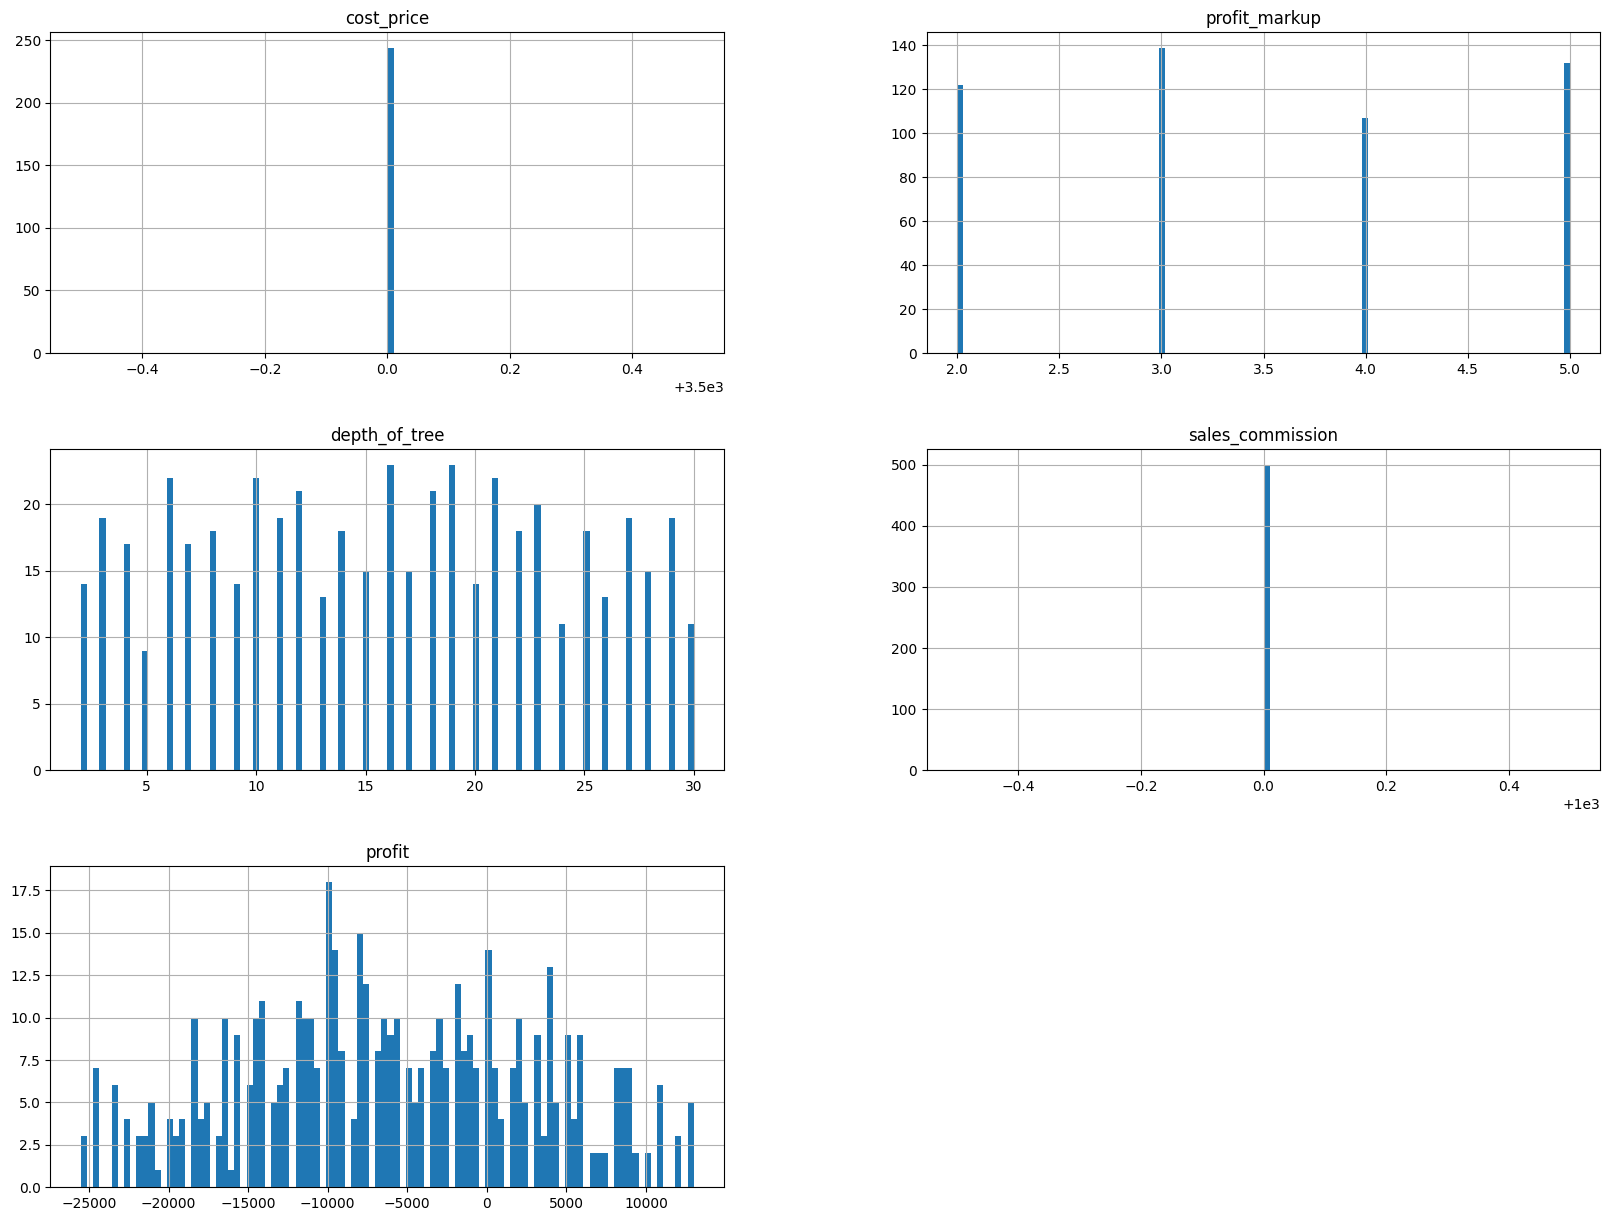


Матрица диаграмм рассеяния:


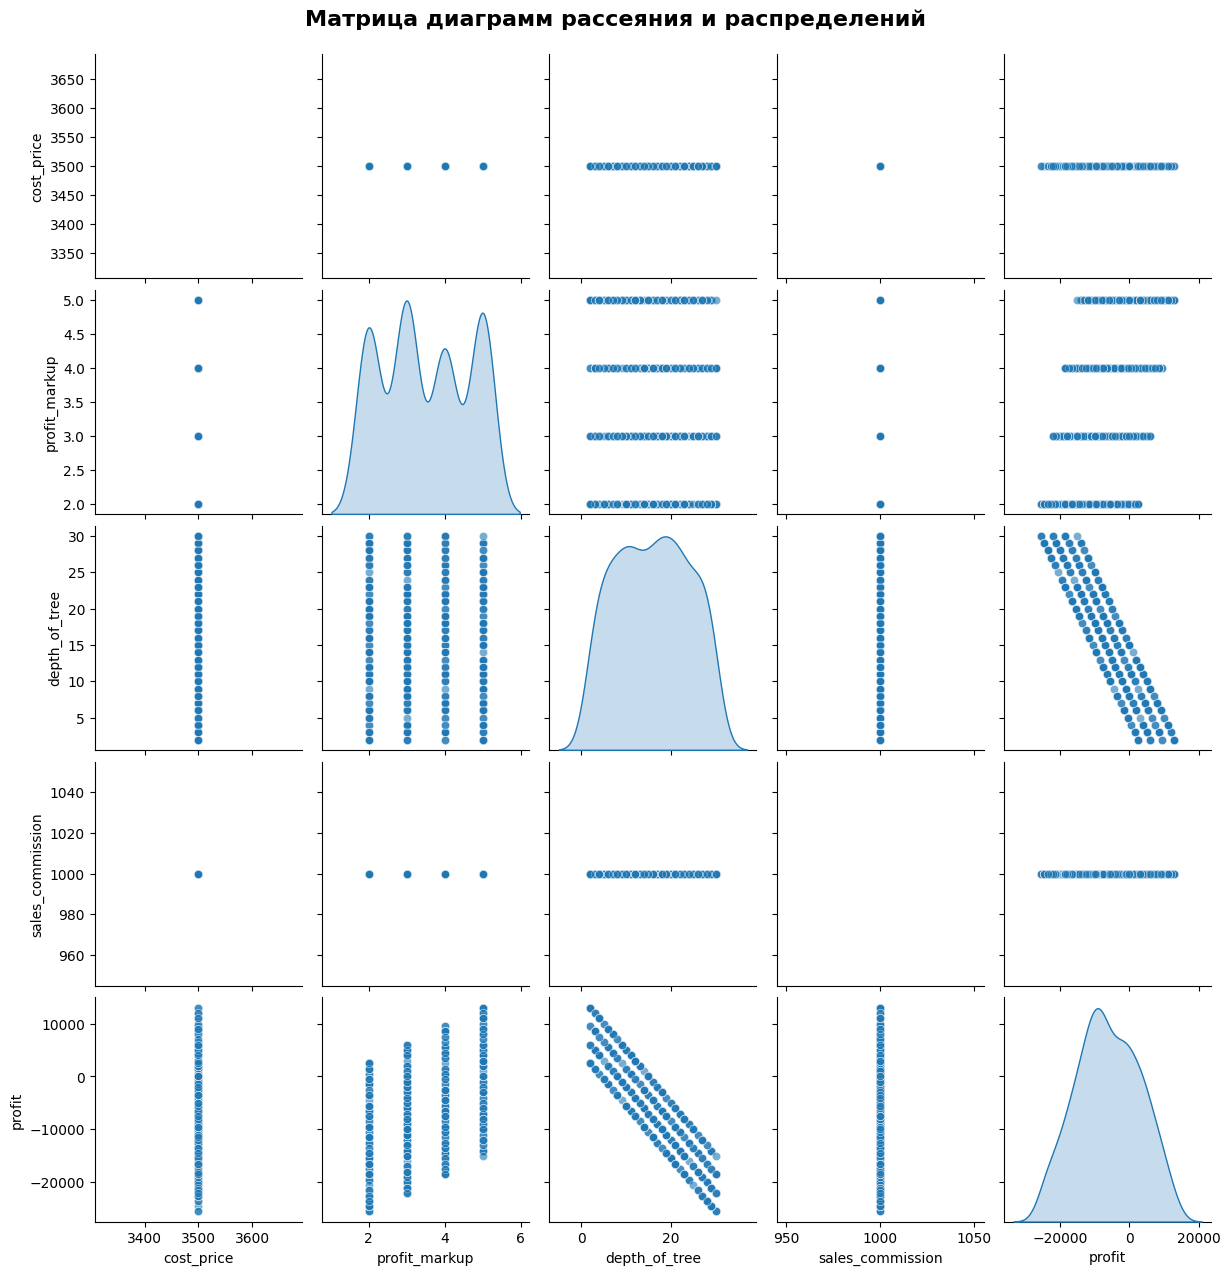

In [7]:
%matplotlib inline
df.hist(bins=100, figsize=(20,15))
plt.show()

# Матрица диаграмм рассеяния
print("\nМатрица диаграмм рассеяния:")
sns.pairplot(df, diag_kind='kde', plot_kws={'alpha': 0.6})
plt.suptitle('Матрица диаграмм рассеяния и распределений', y=1.02, fontsize=16, fontweight='bold')
plt.show()

In [8]:
df['cost_price'] = df['cost_price'].fillna(df['cost_price'].median())
print("Пропущенные значения после обработки:")
print(df.isnull().sum())
df

Количество строк до очистки: 500
Пропущенные значения после обработки:
cost_price          0
profit_markup       0
depth_of_tree       0
sales_commission    0
profit              0
dtype: int64


,cost_price,profit_markup,depth_of_tree,sales_commission,profit
0,3500.0,2,21,1000,-16500
1,3500.0,2,26,1000,-21500
2,3500.0,2,23,1000,-18500
3,3500.0,3,12,1000,-4000
4,3500.0,2,12,1000,-7500
...,...,...,...,...,...
495,3500.0,5,12,1000,3000
496,3500.0,3,8,1000,0
497,3500.0,2,10,1000,-5500
498,3500.0,4,21,1000,-9500


Проанализируем корреляционную зависимость между признаками

Корреляционная матрица:
                  cost_price  profit_markup  depth_of_tree  sales_commission  \
cost_price               NaN            NaN            NaN               NaN   
profit_markup            NaN       1.000000      -0.021562               NaN   
depth_of_tree            NaN      -0.021562       1.000000               NaN   
sales_commission         NaN            NaN            NaN               NaN   
profit                   NaN       0.453341      -0.900905               NaN   

                    profit  
cost_price             NaN  
profit_markup     0.453341  
depth_of_tree    -0.900905  
sales_commission       NaN  
profit            1.000000  


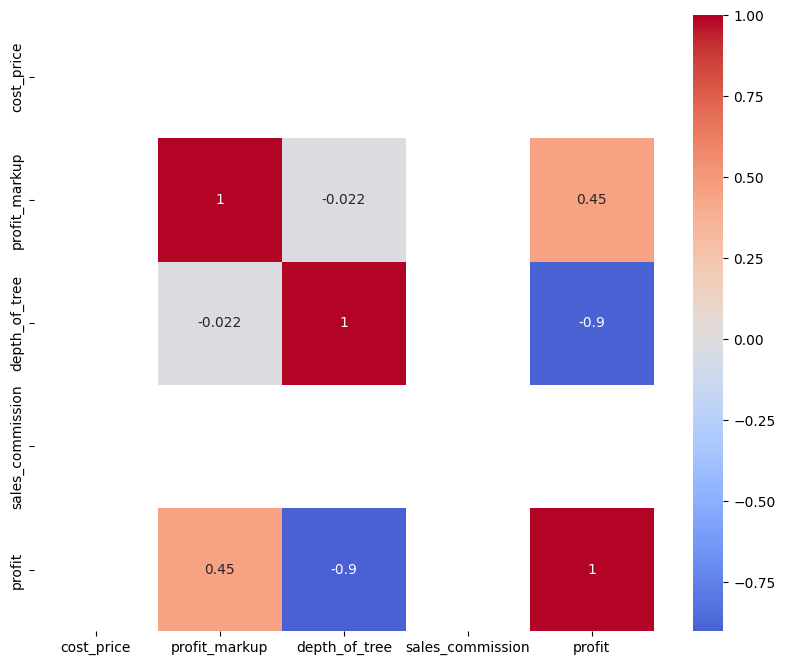

In [9]:
corr_matrix = df.corr()
print("Корреляционная матрица:")
print(corr_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.show()

Добавим новые атрибуты в набор данных:


1.   total_cost - общая себестоимость
2.   profit_per_depth - прибыль, нормированная на глубину дерева решений
3. markup_depth_interaction - как влияет наценка при разных уровнях глубины
4. cost_markup_ratio - соотношение себестоимости и наценки



In [10]:
df_fe = df.copy()
df_fe['total_cost'] = df_fe['cost_price'] + df_fe['sales_commission']
df_fe['profit_per_depth'] = df_fe['profit'] / (df_fe['depth_of_tree'] + 1)
df_fe['markup_depth_interaction'] = df_fe['profit_markup'] * df_fe['depth_of_tree']
df_fe['cost_markup_ratio'] = df_fe['cost_price'] / (df_fe['profit_markup'] + 1)



Выполним отбор существенных признаков.

Корреляция признаков с целевой переменной profit:
profit                      1.000000
depth_of_tree              -0.900905
profit_per_depth            0.809336
markup_depth_interaction   -0.504728
profit_markup               0.453341
cost_markup_ratio          -0.446633
Name: profit, dtype: float64


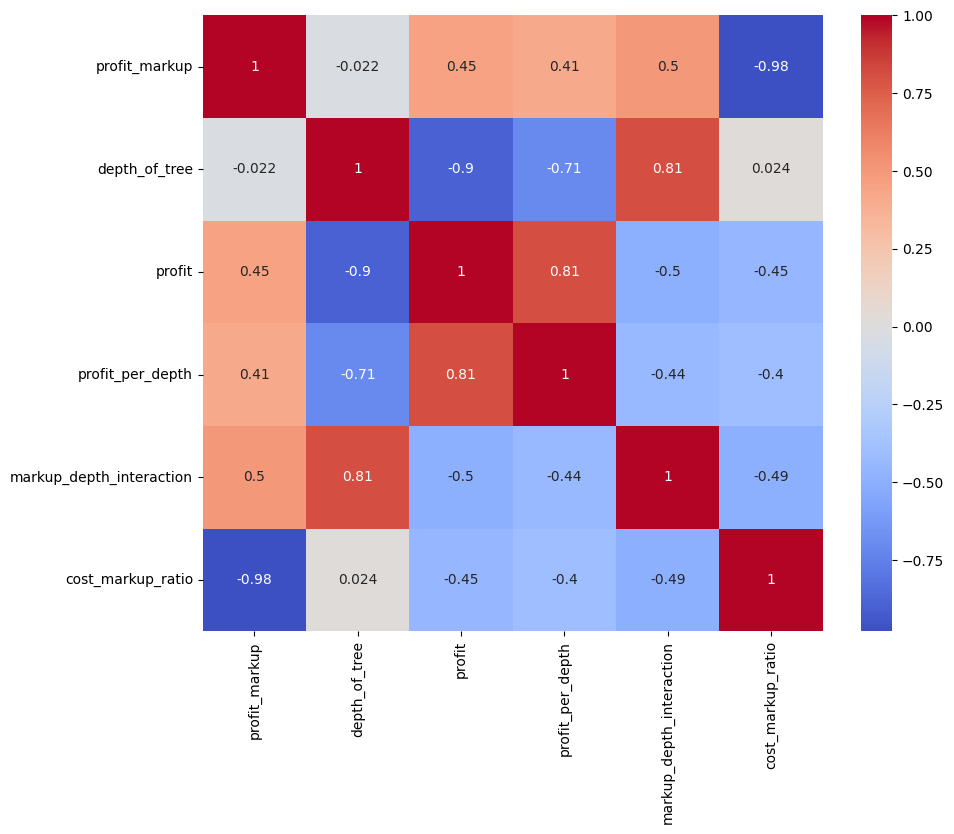

In [59]:
corr_matrix = df_fe.corr()
valid_features = corr_matrix['profit'].dropna().index

corr_matrix_clean = corr_matrix.loc[valid_features, valid_features]
target_corr = corr_matrix_clean['profit'].sort_values(
    key=abs, ascending=False
)

print("Корреляция признаков с целевой переменной profit:")
print(target_corr)
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix_clean,
    annot=True,
    cmap="coolwarm",
    center=0
)

plt.show()

Корреляция признаков с целевой переменной profit:
profit                      1.000000
depth_of_tree              -0.900905
profit_per_depth            0.809336
markup_depth_interaction   -0.504728
profit_markup               0.453341
cost_markup_ratio          -0.446633
cost_price                       NaN
sales_commission                 NaN
total_cost                       NaN
Name: profit, dtype: float64


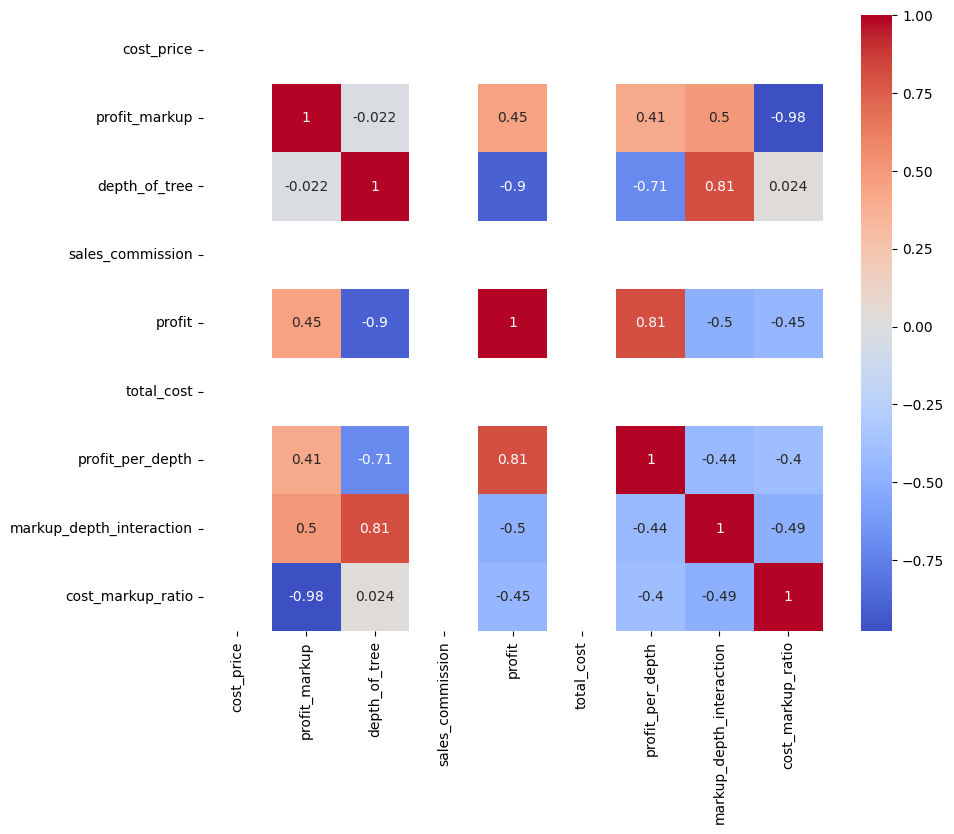

In [56]:
corr_matrix = df_fe.corr()
# Выбираем признаки с высокой корреляцией с целевой переменной
target_corr = (corr_matrix['profit'].sort_values(key=abs, ascending=False))
print("Корреляция признаков с целевой переменной profit:")
print(target_corr)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.show()

In [58]:
significant_features = target_corr[abs(target_corr) > 0.1].index.tolist()
significant_features.remove('profit')
print(f"\nСущественные признаки: {significant_features}")


Существенные признаки: ['depth_of_tree', 'profit_per_depth', 'markup_depth_interaction', 'profit_markup', 'cost_markup_ratio']


Сформируем набор данных из существенных признаков.

In [60]:
df_significant = df_fe[significant_features + ['profit']].copy()
print(f"\nРазмерность набора с существенными признаками: {df_significant.shape}")


Размерность набора с существенными признаками: (500, 6)


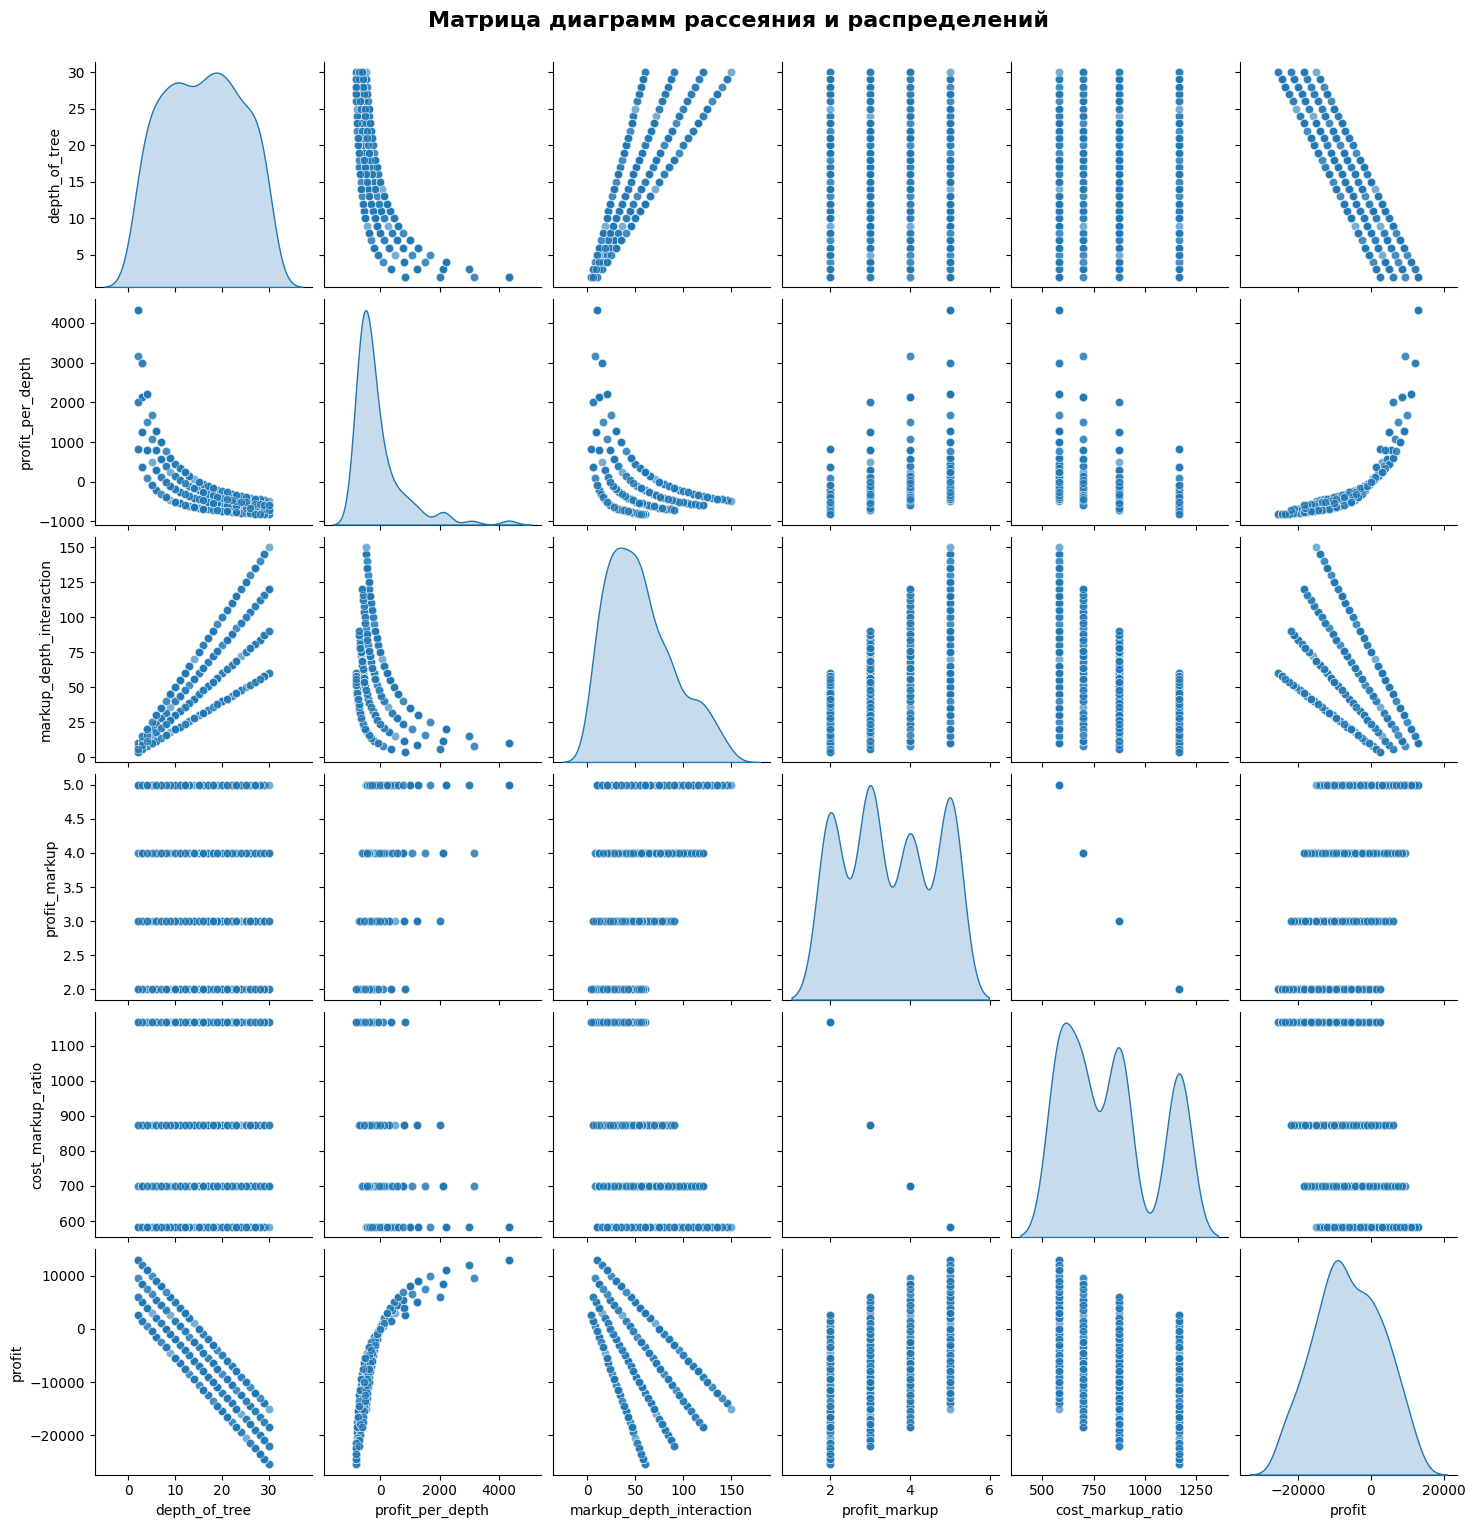

In [63]:
sns.pairplot(df_significant, diag_kind='kde', plot_kws={'alpha': 0.6})
plt.suptitle('Матрица диаграмм рассеяния и распределений', y=1.02, fontsize=16, fontweight='bold')
plt.show()

profit vs depth_of_tree

Очень сильная линейная отрицательная зависимость

Чёткие параллельные линии → формульная структура.

Глубина — ключевой фактор убыточности.



---



profit vs profit_per_depth

Нелинейная монотонная зависимость

Чем выше profit_per_depth, тем выше итоговая прибыль.

Особенно хорошо разделяются положительные и отрицательные значения.



---


profit vs markup_depth_interaction

Мощная отрицательная связь

При росте взаимодействия прибыль падает.

Видны несколько «вееров» линий.

Признак отлично объясняет комбинированный эффект.


---


profit vs profit_markup

Ступенчатая положительная зависимость

Наценка увеличивает прибыль,но эффект ограничен глубиной.




---



profit vs cost_markup_ratio

Отрицательная зависимость

Чем выше отношение затрат к наценке, тем ниже прибыль.


Выполним преобразование данных для обоих наборов (исходного и
сформированного) методом Нормализации.

In [14]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer(norm="l2")

X = df.drop(columns=["profit"]).values
y = df["profit"].values.reshape(-1, 1)

X_norm = normalizer.fit_transform(X)
y_norm = y

X_sel = df_significant.drop(columns=["profit"]).values
y_sel = df_significant["profit"].values.reshape(-1, 1)

X_sel_norm = normalizer.fit_transform(X_sel)
y_sel_norm = y_sel


Разделим данные:

1.   Исходные (original)
2.   Преобразованные исходные (original_normalized)
3.   Построенные (selected)
4.   Преобразованные построенные (selected_normalized)



In [15]:
def split_data(X, y):
    X_train, X_tmp, y_train, y_tmp = train_test_split(
        X, y, test_size=0.1, random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_tmp, y_tmp, test_size=0.5, random_state=42
    )
    return X_train, X_val, X_test, y_train, y_val, y_test

data_sets = {
    "original": split_data(X, y),
    "original_normalized": split_data(X_norm, y_norm),
    "selected": split_data(X_sel, y_sel),
    "selected_normalized": split_data(X_sel_norm, y_sel_norm)
}


In [16]:
def build_dense_model(input_dim, l2_lambda=1e-4):
    model = Sequential([
        Dense(
            64,
            activation="relu",
            input_dim=input_dim,
            kernel_regularizer=l2(l2_lambda)
        ),
        Dropout(0.3),

        Dense(
            32,
            activation="relu",
            kernel_regularizer=l2(l2_lambda)
        ),

        Dense(1)])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="mse"
    )

    return model



In [71]:
from tensorflow.keras.regularizers import l1_l2

def build_rnn_model(input_shape, l2_lambda=1e-4):
    model = Sequential([
        SimpleRNN(
            64,
            activation="tanh",
            return_sequences=True,
            input_shape=input_shape,
            kernel_regularizer=l1_l2(l1=0, l2=l2_lambda*0.1),
            recurrent_regularizer=l1_l2(l1=0, l2=l2_lambda*0.05)
        ),
        Dropout(0.3),

        SimpleRNN(
            32,
            activation="tanh",
            kernel_regularizer=l1_l2(l1=0, l2=l2_lambda*0.1),
            recurrent_regularizer=l1_l2(l1=0, l2=l2_lambda*0.05)
        ),

        Dense(16, activation="tanh"),
        Dense(1)
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="mse"
    )

    return model

In [74]:
def evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train, epochs=30, batch_size=8, verbose=0)
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)
    return rmse, r2


In [37]:
results = []

for name, (X_tr, X_val, X_te, y_tr, y_val, y_te) in data_sets.items():

    dense = build_dense_model(X_tr.shape[1])
    rmse, r2 = evaluate_model(dense, X_tr, y_tr, X_val, y_val)
    results.append([name, "Dense", rmse, r2])

    X_tr_rnn = X_tr.reshape(X_tr.shape[0], 1, X_tr.shape[1])
    X_val_rnn = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    rnn = build_rnn_model((1, X_tr.shape[1]))
    rmse, r2 = evaluate_model(rnn, X_tr_rnn, y_tr, X_val_rnn, y_val)
    results.append([name, "SimpleRNN", rmse, r2])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


Проанализируем полученные данные и найдем лучшую модель и лучший набор данных.

In [38]:
results_df = pd.DataFrame(results, columns=["Dataset", "Model", "RMSE", "R2"])
results_df

,Dataset,Model,RMSE,R2
0,original,Dense,6767.361968,0.104824
1,original,SimpleRNN,8436.253197,-0.391133
2,original_normalized,Dense,7156.623506,-0.001119
3,original_normalized,SimpleRNN,7230.905338,-0.022009
4,selected,Dense,1057.808229,0.978128
5,selected,SimpleRNN,7551.610159,-0.114676
6,selected_normalized,Dense,3312.521094,0.785520
7,selected_normalized,SimpleRNN,2911.320834,0.834328


1. Отбор признаков уменьшил количество ошибок и объясненная дисперсия ростет
2. Dense существенно лучше SimpleRNN для ненормированных данных, R2 - отрицательный, так как в данных нет временной структуры.
3. Нормализация помогла SimpleRNN
4. Нормализация ухудшила Dense на отобранных признаках

Мы видим, что среднеквадратическая ошибка RMSE меньше у полносвязной нейросетевой регрессионной модели, чем простой рекурентной модели.
Поэтому первая лучше подходит для подбора гиперпараметров модели.

In [39]:
best_row = results_df.loc[results_df["RMSE"].idxmin()]


best_dataset = best_row["Dataset"]
best_model = best_row["Model"]
best_r2 = best_row["R2"]
best_rmse = best_row["RMSE"]

# Лучший датасет (получен ранее)
X_tr, X_val, X_te, y_tr, y_val, y_te = data_sets[best_dataset]

# Для GridSearch объединяем train + val
X_gs = np.vstack([X_tr, X_val])
y_gs = np.vstack([y_tr, y_val])

In [43]:
def create_dense_model(neurons1=64, neurons2=32, learning_rate=0.001, meta=None):
    model = Sequential([
        Input(shape=(meta["n_features_in_"],)),
        Dense(neurons1, activation="relu"),
        Dense(neurons2, activation="relu"),
        Dense(1)
    ])
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="mse"
    )
    return model

dense_estimator = KerasRegressor(
model=create_dense_model,
epochs=50,
batch_size=8,
verbose=0
)

param_grid_dense = {
    "model__neurons1": [16, 32, 64],
    "model__neurons2": [8, 16],
    "model__learning_rate": [0.001, 0.0001]
}

from sklearn.model_selection import GridSearchCV

grid_dense = GridSearchCV(
    estimator=dense_estimator,
    param_grid=param_grid_dense,
    cv=3,
    scoring="neg_root_mean_squared_error"
)

grid_dense.fit(X_gs, y_gs)

print("Лучшие гиперпараметры Dense:")
print(grid_dense.best_params_)




Лучшие гиперпараметры Dense:
{'model__learning_rate': 0.001, 'model__neurons1': 64, 'model__neurons2': 16}


Для лучшей модели на лучшем наборе данных оценить качество на тестовом
наборе.

In [44]:
best_dense = grid_dense.best_estimator_

y_test_pred = best_dense.predict(X_te)

rmse_test = np.sqrt(mean_squared_error(y_te, y_test_pred))
r2_test = r2_score(y_te, y_test_pred)

print("\nКачество на тестовой выбрке")
print(f"RMSE (test): {rmse_test:.4f}")
print(f"R2   (test): {r2_test:.4f}")


Качество на тестовой выбрке
RMSE (test): 998.7652
R2   (test): 0.9807


In [45]:
comparison_df = pd.DataFrame({
    "Модель": ["До Grid Search", "После Grid Search"],
    "RMSE (test)": [best_rmse, rmse_test],
    "R2 (test)": [best_r2, r2_test]
})

display(comparison_df)

,Модель,RMSE (test),R2 (test)
0,До Grid Search,1057.808229,0.978128
1,После Grid Search,998.765206,0.980664


RMSE уменьшился -> более точные прогнозы
R2 -> модель стала объяснять большую долю дисперсии целевой переменной

ВЫВОД:
Установлено, что отбор существенных признаков оказывает значительно большее влияние на качество модели, чем нормализация данных.
Модели, обученные на наборе данных с отобранными признаками (selected), показали наилучшие значения метрик качества (RMSE и R²).

Использование нормализации без предварительного отбора признаков не привело к улучшению качества моделей, а в ряде случаев даже ухудшило результаты.


---


В ходе выполнения работы было выявлено, что полносвязная нейросеть (Dense) существенно превосходит модель SimpleRNN по качеству регрессии с данным датасетом:

*   Dense-модель показала высокие значения коэффициента детерминации R² (до 0.97–0.98)
*   SimpleRNN продемонстрировала нестабильные и отрицательные значения R² на большинстве наборов данных   

Это объясняется тем, что исследуемые данные не обладают временной или последовательной структурой, необходимой для эффективной работы рекуррентных нейронных сетей.


---

По результатам сравнения всех комбинаций было установлено, что:

*   лучшей моделью является Dense
*   лучшим набором данных является набор с отобранными признаками (selected)

Именно эта комбинация обеспечила минимальное значение RMSE и максимальное значение R² на валидационной и тестовой выборках.


---

Для лучшей модели на лучшем наборе данных был выполнен поиск оптимальных гиперпараметров методом Grid Search.

Результаты показали, что:


*   после подбора гиперпараметров наблюдается улучшение качества на тестовой выборке
*   RMSE снизилось, а R² увеличился, что свидетельствует о лучшей обобщающей способности модели

При этом на валидационной выборке улучшение было незначительным, что указывает на близость исходных гиперпараметров к оптимальным.
